In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
from localreg import *
import rbf as rbf

In [120]:
n = 1000
np.random.seed(123)
X_1 = np.random.rand(n)
m_1 = (np.cos(2*np.pi*X_1))**2 + np.log(4/3 + X_1)
eps1 = np.random.normal(0, 0.1, n)
Y_1 = m_1 + eps1

dat1 = pd.DataFrame({'X': X_1, 'Y': Y_1})
dat1.to_csv('sim_dat1.csv', index=False)

np.random.seed(123)
X_2 = scipy.stats.beta.rvs(a=2, b=2, size=n)
m_2 = 50*np.exp(-8*(1-2*X_2)**4)*(1-2*X_2)
eps2 = np.random.normal(0, 2, n)
Y_2 = m_2 + eps2

dat2 = pd.DataFrame({'X': X_2, 'Y': Y_2})
dat2.to_csv('sim_dat2.csv', index=False)

### First-Order Derivative Estimation

In [43]:
def KDE(x, data, h=None, wt=None):
    '''
    The d-dim Euclidean KDE with the Gaussian kernel.
    
    Parameters
    ----------
        x: (m,d)-array
            The coordinates of m query points in the d-dim Euclidean space.
    
        data: (n,d)-array
            The coordinates of n random sample points in the d-dimensional 
            Euclidean space.
       
        h: float
            The bandwidth parameter. (Default: h=None. Then the Silverman's 
            rule of thumb is applied. See Chen et al.(2016) for details.)
            
        wt: (n,)-array
            The weights of kernel density contributions for n random sample 
            points. (Default: wt=None, that is, each data point has an equal
            weight "1/n".)
    
    Return
    ----------
        f_hat: (m,)-array
            The corresponding kernel density estimates at m query points.
    '''
    n = data.shape[0]  ## Number of data points
    d = data.shape[1]  ## Dimension of the data
    
    if h is None:
        # Apply Silverman's rule of thumb to select the bandwidth parameter 
        # (Only works for Gaussian kernel)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(data, axis=0))
        print("The current bandwidth is "+ str(h) + ".\n")
    
    f_hat = np.zeros((x.shape[0], ))
    if wt is None:
        wt = np.ones((n,))/n
    for i in range(x.shape[0]):
        f_hat[i] = np.sum(wt*np.exp(np.sum(-((x[i,:] - data)/h)**2, axis=1)/2))/ \
                   ((2*np.pi)**(d/2)*np.prod(h))
    return f_hat

def KernelCDF(x, data, h=None, wt=None):
    '''
    The estimated CDF by KDE with the Gaussian kernel.
    
    Parameters
    ----------
        x: (m,)-array
            The coordinates of m query points.
    
        data: (n,d)-array
            The coordinates of n random sample points.
       
        h: float
            The bandwidth parameter. (Default: h=None. Then the Silverman's 
            rule of thumb is applied. See Chen et al.(2016) for details.)
            
        wt: (n,)-array
            The weights of kernel density contributions for n random sample 
            points. (Default: wt=None, that is, each data point has an equal
            weight "1/n".)
    
    Return
    ----------
        F_hat: (m,)-array
            The corresponding CDF estimates at m query points.
    '''
    n = data.shape[0]  ## Number of data points
    d = 1
    
    if h is None:
        # Apply Silverman's rule of thumb to select the bandwidth parameter 
        # (Only works for Gaussian kernel)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(data, axis=0))
        print("The current bandwidth is "+ str(h) + ".\n")
    
    F_hat = np.zeros((x.shape[0], ))
    if wt is None:
        wt = np.ones((n,))/n
    for i in range(x.shape[0]):
        F_hat[i] = np.sum(wt*scipy.stats.norm.cdf((x[i] - data)/h, loc=0, scale=1))
    return F_hat
    

def DerivEstQuotient(Y, X, k, h=None):
    '''
    Noisy derivative estimate by weighted difference quotient.
    
    Parameters
    ----------
        Y: (m,)-array
            The y coordinates of m data points.
        
        X: (m,)-array
            The x coordinates of m data points.
            
        k: float
            Number of symmetric difference quotients around a data point.
            
        h: float
            The bandwidth parameter. (Default: h=None. Then the Silverman's 
            rule of thumb is applied. See Chen et al.(2016) for details.)
    '''
    n = X.shape[0]  ## Number of data points
    d = 1
    if h is None:
        # Apply Silverman's rule of thumb to select the bandwidth parameter 
        # (Only works for Gaussian kernel)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(X, axis=0))
        print("The current bandwidth is "+ str(h) + ".\n")
        
    U = KernelCDF(x=X, data=X, h=h, wt=None)
    den_est = KDE(x=X.reshape(-1,1), data=X.reshape(-1,1), h=h, wt=None)
    U_ord = np.sort(U)
    X_ord = X[np.argsort(U)]
    den_est_ord = den_est[np.argsort(U)]
    Y_ord = Y[np.argsort(U)]
    
    Y_deri = np.zeros_like(Y_ord)
    for i in range(n):
        if i < k:
            w1 = U_ord[(i+1):(2*i+1)] - np.flip(U_ord[0:i])
            w2 = U_ord[(2*i-1):k] - U_ord[i]
            w1 = w1/(sum(w1**2) + sum(w2**2))
            w2 = w2/(sum(w1**2) + sum(w2**2))
            Y_deri[i] = sum(w1*(Y_ord[(i+1):(2*i+1)] - np.flip(Y_ord[0:i]))) + sum(w2*(Y_ord[(2*i-1):k] - Y_ord[i]))
        elif (i >= k) and (i < n-k):
            weights = U_ord[(i+1):(i+1+k)] - np.flip(U_ord[(i-k):i])
            weights = weights/np.sum(weights**2)
            Y_deri[i] = np.sum(weights*(Y_ord[(i+1):(i+1+k)] - np.flip(Y_ord[(i-k):i])))
        else:
            w1 = U_ord[(i+1):] - np.flip(U_ord[(2*i-n+1):i])
            w2 = U_ord[i] - U_ord[(i-k):(2*i-n)]
            w1 = w1/(sum(w1**2) + sum(w2**2))
            w2 = w2/(sum(w1**2) + sum(w2**2))
            Y_deri[i] = sum(w1*(Y_ord[(i+1):] - np.flip(Y_ord[(2*i-n+1):i]))) + sum(w2*(Y_ord[i] - Y_ord[(i-k):(2*i-n)]))
    return Y_deri, U_ord, X_ord, den_est_ord

def ErrorVar(Y):
    n = Y.shape[0]
    return np.mean((0.809*Y[:(n-2)] - 0.5*Y[1:(n-1)] - 0.309*Y[2:])**2)

In [44]:
def LocalPolyReg(Y, X, x_eval=None, degree=3, deriv_ord=0, h=None, kernel=rbf.epanechnikov):
    '''
    Local polynomial regression in one dimension.
    
    Parameters
    ----------
        Y: (m,)-array
            The y coordinates of m data points.
        
        X: (m,)-array
            The x coordinates of m data points.
            
        x_eval: (k,)-array
            Vector of evaluation points. (Default: x_eval=None. Then, x_eval=X.)
            
        degree: int
            Degree of local polynomials. (Default: degree=2.)
            
        deriv_ord: int
            The order of derivatives of the regression function that are estimated. 
            (Default: deriv_ord=0. Then, it is the usual local polynomial regression.)
            
        h: float
            The bandwidth parameter. (Default: h=None. Then the Silverman's 
            rule of thumb is applied. See Chen et al.(2016) for details.)
    '''
    if x_eval is None: 
        x_eval = X.copy()
        
    n = X.shape[0]  ## Number of data points
    d = 1
    if h is None:
        # Apply the rule-of-thumb bandwidth parameter in Section 4.2 of Fan and Gijbels (1996).
        # (!!!!! Program out this part !!!!)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(X, axis=0))
        print("The current bandwidth for local polynomial regression is "+ str(h) + ".\n")
    
    Y_est = np.zeros_like(x_eval)
    for i in range(x_eval.shape[0]):
        weights = kernel((X-x_eval[i])/h)
        # Filter out the data points with zero weights to 
        # speed up regressions with kernels of local support.
        inds = np.where(np.abs(weights)>1e-26)[0]
        X_dat = np.zeros((n, degree+1))
        for p in range(degree + 1):
            X_dat[:,p] = (X - x_eval[i])**p
        S = np.sqrt(weights)[inds]
        lhs = np.dot(np.diag(S), X_dat[inds,:])
        rhs = S*Y[inds]
        rcond = np.finfo(lhs.dtype).eps * max(*lhs.shape)
        beta = np.linalg.lstsq(lhs, rhs, rcond=rcond)[0]
        # W = np.diag(weights)
        # beta = np.dot(np.linalg.inv(np.dot(np.dot(X_dat.T, W), X_dat)), np.dot(np.dot(X_dat.T, W), Y))
        Y_est[i] = math.factorial(deriv_ord)*beta[deriv_ord]
    return Y_est

In [126]:
def OptK(Y, U, k_range=None, h=None, kernel=rbf.gaussian):
    n = U.shape[0]  ## Number of data points
        
    if k_range is None:
        k_range = np.arange(1, np.floor((n-1)/2))
    u_qry = np.linspace(min(U), max(U), 200)
    r2_est = LocalPolyReg(Y, U, x_eval=u_qry, degree=3, deriv_ord=2, h=h, kernel=kernel)
    B = max(abs(r2_est))
    sigma_e_sq = ErrorVar(Y)
    asym_bias_sq = 9*(B**2)*(k_range**2)*(k_range + 1)**2/(16*(n+1)**2*(2*k_range+1)**2)
    asym_var = 3*sigma_e_sq*(n+1)**2/(k_range*(k_range+1)*(2*k_range+1))
    return k_range[np.argmin(asym_bias_sq + asym_var)]

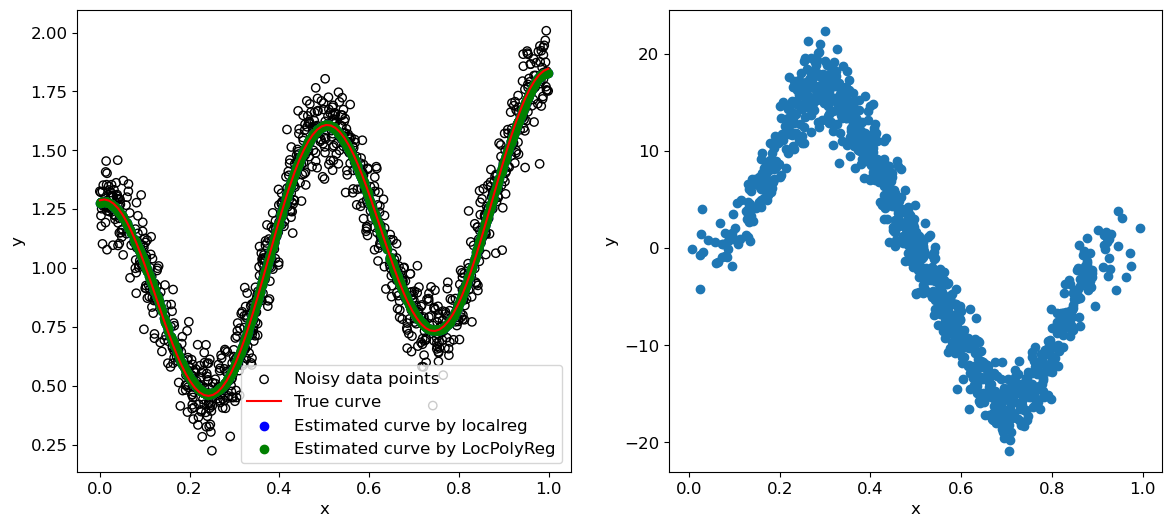

In [127]:
x_qry = np.linspace(min(X_1), max(X_1), 100)
Y_true1 = (np.cos(2*np.pi*x_qry))**2 + np.log(4/3 + x_qry)
Y_est1 = localreg(X_1, Y_1, x0=None, degree=2, kernel=rbf.epanechnikov, radius=0.1, frac=None)
Y_est11 = LocalPolyReg(Y_1, X_1, x_eval=None, degree=2, deriv_ord=0, h=0.1, kernel=rbf.epanechnikov)

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.scatter(X_1, Y_1, facecolors='none', edgecolors='black', label='Noisy data points')
plt.plot(x_qry, Y_true1, color='red', label='True curve')
plt.scatter(X_1, Y_est1, color='blue', label='Estimated curve by localreg')
plt.scatter(X_1, Y_est11, color='green', label='Estimated curve by LocPolyReg')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.scatter(X_2, Y_2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [47]:
(abs(Y_est1 - Y_est11) < 1e-12).all()

True

In [49]:
def RSSBandwidth(Y, U, k, h_range=None, deg=3):
    if h_range is None:
        h_range = np.linspace(0.001, 1, 101)
        print("The optimal bandwidth is chosen from "+ str(h) + ".\n")
    Y_int = Y[k:(n-k)]
    U_int = U[k:(n-k)]
    RSS = np.zeros((len(h_range),))
    for i in range(len(h_range)):
        r_est = LocalPolyReg(Y_int, U_int, x_eval=None, degree=deg, deriv_ord=0, h=h_range[i], 
                             kernel=rbf.bigaussian)
        RSS[i] = np.mean((r_est - Y_int)**2)
    return h_range[np.argmin(RSS)]

### Simulation 1 (Equation (23))

26
0.055


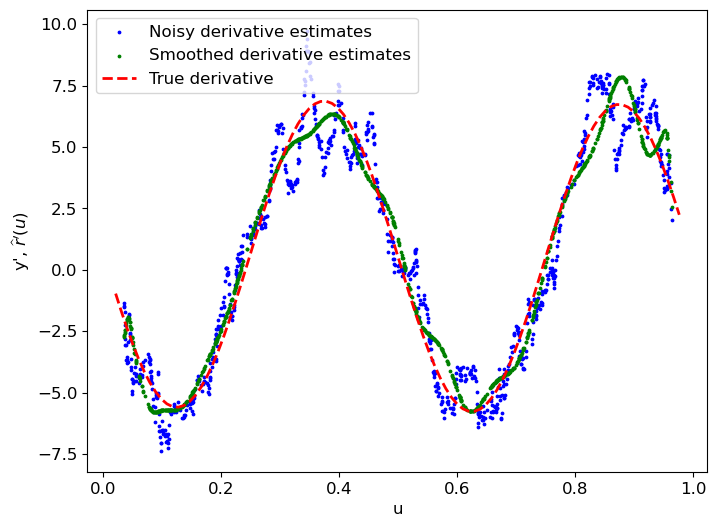

In [128]:
h_den = 0.05320984
# h_den = 0.1
U_1 = KernelCDF(x=X_1, data=X_1, h=h_den, wt=None)
# k_num = OptK(Y_1, U_1, k_range=np.arange(1, 500), h=h_den, kernel=rbf.gaussian)
k_num = 26
print(k_num)
Y_deriv1, U_ord1, X_ord1, den_est1 = DerivEstQuotient(Y_1, X_1, k=k_num, h=h_den)
h_opt = RSSBandwidth(Y_deriv1, U_ord1, k=k_num, h_range=np.linspace(0.04, 0.1, 13), deg=3)
print(h_opt)
h_opt = 1.01431*h_opt

u_qry = np.linspace(min(U_ord1), max(U_ord1), 100)
True_deriv1 = -2*np.pi*np.sin(4*np.pi*u_qry) + 3/(3*u_qry+4)

qry_range = np.arange(k_num-1, n-k_num)
Y_deriv_sm1 = LocalPolyReg(Y_deriv1[qry_range], U_ord1[qry_range], x_eval=None, degree=3, deriv_ord=0, 
                           h=h_opt, kernel=rbf.bigaussian)

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(8,6))
plt.scatter(U_ord1[qry_range], Y_deriv1[qry_range], color='blue', s=3, 
            label='Noisy derivative estimates')
plt.scatter(U_ord1[qry_range], Y_deriv_sm1, color='green', s=3, label='Smoothed derivative estimates')
plt.plot(u_qry, True_deriv1, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend()
plt.xlabel('u')
plt.ylabel(r"y', $\widehat{r}'(u)$")
plt.show()

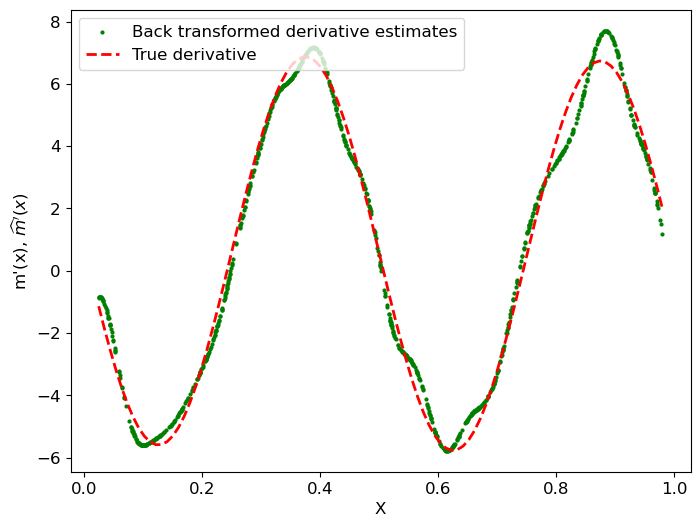

In [85]:
qry_range = np.arange(k_num-1, n-k_num)
Y_deriv_sm1 = LocalPolyReg(Y_deriv1, U_ord1, x_eval=None, degree=3, deriv_ord=0, 
                           h=h_opt, kernel=rbf.bigaussian)
Y_deriv_trans1 = Y_deriv_sm1*den_est1

plt.figure(figsize=(8,6))
plt.scatter(X_ord1[qry_range], Y_deriv_trans1[qry_range], color='green', s=4, 
         label='Back transformed derivative estimates')

x_qry = np.linspace(min(X_ord1[qry_range]), max(X_ord1[qry_range]), 100)
True_deriv1 = -2*np.pi*np.sin(4*np.pi*x_qry) + 3/(3*x_qry+4)

plt.plot(x_qry, True_deriv1, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend(loc='upper left')
plt.xlabel('X')
plt.ylabel(r"m'(x), $\widehat{m}'(x)$")
plt.show()

### Simulation 2 (Equation (24))

22
0.07500000000000001


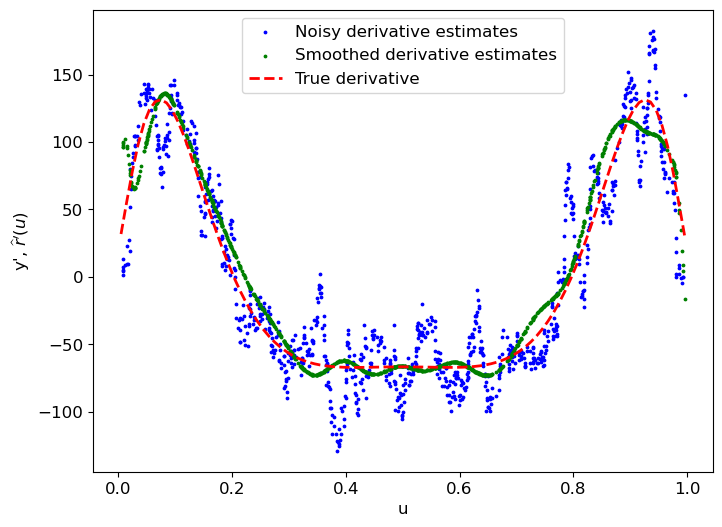

In [87]:
h_den = 0.05853336
U_2 = KernelCDF(x=X_2, data=X_2, h=h_den, wt=None)
# k_num = OptK(Y_2, U_2, k_range=np.arange(1, 500), h=h_den, kernel=rbf.gaussian)
k_num = 22
print(k_num)
Y_deriv2, U_ord2, X_ord2, den_est2 = DerivEstQuotient(Y_2, X_2, k=k_num, h=h_den)
h_opt = RSSBandwidth(Y_deriv2, U_ord2, k=k_num, h_range=np.linspace(0.04, 0.1, 13), deg=3)
print(h_opt)
h_opt = 1.01431*h_opt

u_qry = np.linspace(min(U_ord2), max(U_ord2), 100)
x_qry = scipy.stats.beta.ppf(u_qry, a=2, b=2)
True_deriv2 = np.exp(-8*((1-2*x_qry)**4))*(3200*(1-2*x_qry)**4-100) / (scipy.stats.beta.pdf(x_qry, a=2, b=2))

# qry_range = np.arange(k_num-1, n-k_num)
qry_range = np.arange(1, n)
Y_deriv_sm2 = LocalPolyReg(Y_deriv2[qry_range], U_ord2[qry_range], x_eval=None, degree=3, deriv_ord=0, 
                           h=h_opt, kernel=rbf.bigaussian)

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(8,6))
plt.scatter(U_ord2[qry_range], Y_deriv2[qry_range], color='blue', s=3, 
            label='Noisy derivative estimates')
plt.scatter(U_ord2[qry_range], Y_deriv_sm2, color='green', s=3, label='Smoothed derivative estimates')
plt.plot(u_qry, True_deriv2, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend()
plt.xlabel('u')
plt.ylabel(r"y', $\widehat{r}'(u)$")
plt.show()

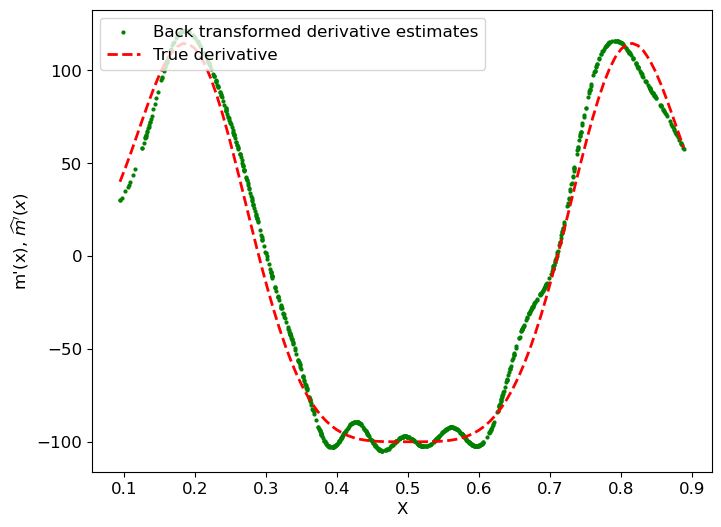

In [83]:
# x_qry = np.linspace(min(X_2), max(X_2), 100)
# True_deriv2 = np.exp(-8*((1-2*x_qry)**4))*(3200*(1-2*x_qry)**4-100)

qry_range = np.arange(k_num-1, n-k_num)
Y_deriv_sm2 = LocalPolyReg(Y_deriv2, U_ord2, x_eval=None, degree=3, deriv_ord=0, 
                           h=h_opt, kernel=rbf.bigaussian)
Y_deriv_trans2 = Y_deriv_sm2*den_est2

plt.figure(figsize=(8,6))
plt.scatter(X_ord2[qry_range], Y_deriv_trans2[qry_range], color='green', s=4, 
         label='Back transformed derivative estimates')

x_qry = np.linspace(min(X_ord2[qry_range]), max(X_ord2[qry_range]), 100)
True_deriv2 = np.exp(-8*((1-2*x_qry)**4))*(3200*(1-2*x_qry)**4-100)

plt.plot(x_qry, True_deriv2, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend(loc='upper left')
plt.xlabel('X')
plt.ylabel(r"m'(x), $\widehat{m}'(x)$")
plt.show()

### Second-Order Derivative Estimation

In [115]:
def SecondDerivEstQuotient(Y, X, k1, k2, h=None):
    '''
    Noisy derivative estimate by weighted difference quotient.
    
    Parameters
    ----------
        Y: (m,)-array
            The y coordinates of m data points.
        
        X: (m,)-array
            The x coordinates of m data points.
            
        k1: float
            Step size of the first-order difference quotients.
            
        k2: float
            Number of symmetric first-order difference quotients around a data point.
            
        h: float
            The bandwidth parameter. (Default: h=None. Then the Silverman's 
            rule of thumb is applied. See Chen et al.(2016) for details.)
    '''
    n = X.shape[0]  ## Number of data points
    d = 1
    if h is None:
        # Apply Silverman's rule of thumb to select the bandwidth parameter 
        # (Only works for Gaussian kernel)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(X, axis=0))
        print("The current bandwidth is "+ str(h) + ".\n")
        
    U = KernelCDF(x=X, data=X, h=h, wt=None)
    den_est = KDE(x=X.reshape(-1,1), data=X.reshape(-1,1), h=h, wt=None)
    U_ord = np.sort(U)
    X_ord = X[np.argsort(U)]
    den_est_ord = den_est[np.argsort(U)]
    Y_ord = Y[np.argsort(U)]
    
    weights = (2*np.arange(1, k2+1) + k1)**2
    weights = weights/np.sum(weights)
    
    Y_aug = np.concatenate([np.zeros((k1+k2,)), Y_ord, np.zeros((k1+k2,))])
    U_aug = np.concatenate([(1e-26)*np.arange(1, k1+k2+1), U_ord, (1e-26)*np.arange(1, k1+k2+1)])
    
    Y_sec = np.zeros_like(Y_ord)
    for i in range(n):
        ind = i + k1+k2
        Y_plus = (Y_aug[(ind+1+k1):(ind+1+k1+k2)] - Y_aug[(ind+1):(ind+1+k2)])/(U_aug[(ind+1+k1):(ind+1+k1+k2)] - U_aug[(ind+1):(ind+1+k2)])
        Y_minus = np.flip(Y_aug[(ind-k1-k2):(ind-k1)] - Y_aug[(ind-k2):ind]) / np.flip(U_aug[(ind-k1-k2):(ind-k1)] - U_aug[(ind-k2):ind])
        U_norm = U_aug[(ind+1+k1):(ind+1+k1+k2)] + U_aug[(ind+1):(ind+1+k2)] - np.flip(U_aug[(ind-k1-k2):(ind-k1)]) - np.flip(U_aug[(ind-k2):ind])
        Y_sec[i] = np.sum(2*weights*((Y_plus - Y_minus) / U_norm))
        
    return Y_sec, U_ord, X_ord, den_est_ord

def OptK1K2(Y, U, k1_range=None, k2_range=None, h=None, kernel=rbf.gaussian):
    n = U.shape[0]  ## Number of data points
    d = 1
    if h is None:
        # Apply Silverman's rule of thumb to select the bandwidth parameter 
        # (Only works for Gaussian kernel in density estimation)
        h = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.mean(np.std(U, axis=0))
        print("The current bandwidth for local polynomial regression is "+ str(h) + ".\n")
        
    if k1_range is None:
        k1_range = np.arange(1, np.floor((n-1)/4))
    if k2_range is None:
        k2_range = np.arange(1, np.floor((n-1)/4))
    u_qry = np.linspace(min(U), max(U), 200)
    r3_est = LocalPolyReg(Y, U, x_eval=u_qry, degree=4, deriv_ord=3, h=h, kernel=kernel)
    B = max(abs(r3_est))
    sigma_e_sq = ErrorVar(Y)
    asym_bias_sq = np.zeros((len(k1_range), len(k2_range)))
    asym_var = np.zeros((len(k1_range), len(k2_range)))
    for i in range(len(k1_range)):
        k1 = k1_range[i]
        for j in range(len(k2_range)):
            k2 = k2_range[j]
            k2_cub = (k2**2)*((k2+1)**2)/4
            k2_sq = k2*(k2+1)*(2*k2+1)/6
            k2_sum = k2*(k2+1)/2
            asym_bias_sq[i,j] = ((B/(n+1))*(2*k2_cub + 3*k1*k2_sq + (5*k1**2/3)*k2_sum + k1**3*k2/3)/(4*k2_sq + k1*2*k2+4*k1*k2_sum))**2
            asym_var[i,j] = 4*(n+1)**4*sigma_e_sq/(k1**2*np.sum((2*np.arange(1, k2+1) + k1)**2))
    asym_mse = asym_bias_sq + asym_var
    k1_ind, k2_ind = np.unravel_index(asym_mse.argmin(), asym_mse.shape)
    return k1_range[k1_ind], k2_range[k2_ind]

[26, 38]
0.05


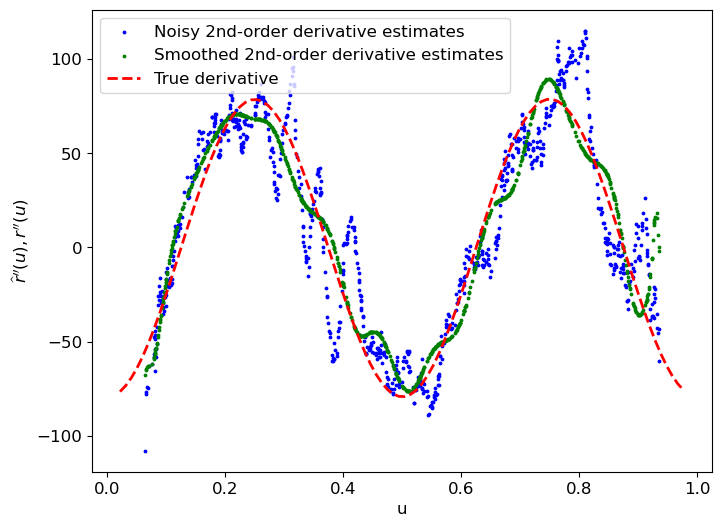

In [116]:
h_den = 0.05320984
# h_den = 0.1
U_1 = KernelCDF(x=X_1, data=X_1, h=h_den, wt=None)
k_1, k_2 = OptK1K2(Y_1, U_1, k1_range=np.arange(1, 101), k2_range=np.arange(2, 101), h=h_den, kernel=rbf.gaussian)
# k_1, k_2 = 42, 23
print([k_1, k_2])
Y_sec1, U_ord1, X_ord1, den_est1 = SecondDerivEstQuotient(Y_1, X_1, k1=k_1, k2=k_2, h=h_den)
h_opt = RSSBandwidth(Y_sec1, U_ord1, k=k_1+k_2, h_range=np.linspace(0.05, 0.1, 11), deg=3)
print(h_opt)
h_opt = 1.01431*h_opt

u_qry = np.linspace(min(U_ord1), max(U_ord1), 100)
True_sec1 = -8*(np.pi**2)*np.cos(4*np.pi*u_qry) - 9/((3*u_qry+4)**2)

qry_range = np.arange(k_1+k_2-1, n-k_1-k_2)
Y_sec_sm1 = LocalPolyReg(Y_sec1[qry_range], U_ord1[qry_range], x_eval=None, degree=3, deriv_ord=0, 
                           h=h_opt, kernel=rbf.bigaussian)

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(8,6))
plt.scatter(U_ord1[qry_range], Y_sec1[qry_range], color='blue', s=3, 
            label='Noisy 2nd-order derivative estimates')
plt.scatter(U_ord1[qry_range], Y_sec_sm1, color='green', s=3, 
            label='Smoothed 2nd-order derivative estimates')
plt.plot(u_qry, True_sec1, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend()
plt.xlabel('u')
plt.ylabel(r"$\widehat{r}''(u), r''(u)$")
plt.show()

### Simulation 3 Equation (27)

In [119]:
np.random.seed(123)
X_3 = np.random.rand(n)
m_3 = 50*np.exp(-8*(1-2*X_3)**4)*(1-2*X_3)
eps3 = np.random.normal(0, 2, n)
Y_3 = m_3 + eps3

dat3 = pd.DataFrame({'X': X_3, 'Y': Y_3})
dat3.to_csv('sim_dat3.csv', index=False)

[33, 47]
0.05


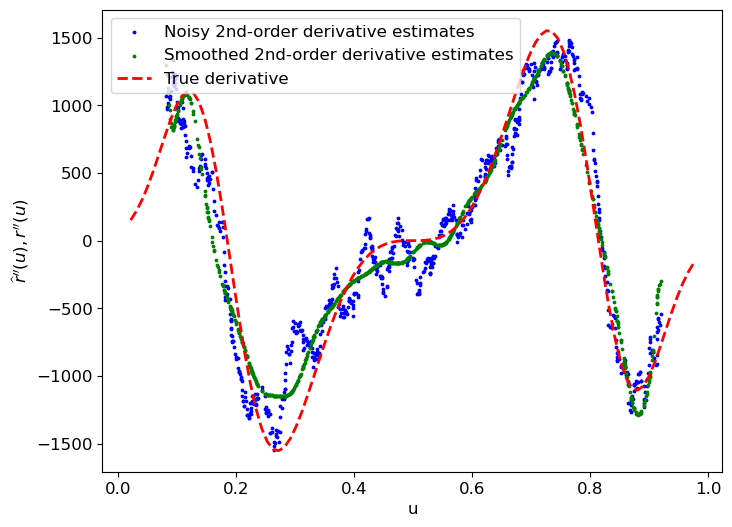

In [125]:
h_den = 0.05320984
# h_den = 0.1
U_3 = KernelCDF(x=X_3, data=X_3, h=h_den, wt=None)
k_1, k_2 = OptK1K2(Y_3, U_3, k1_range=np.arange(1, 101), k2_range=np.arange(1, 101), h=h_den, kernel=rbf.gaussian)
# k_1, k_2 = 44, 24
print([k_1, k_2])
Y_sec3, U_ord3, X_ord3, den_est3 = SecondDerivEstQuotient(Y_3, X_3, k1=k_1, k2=k_2, h=h_den)
h_opt = RSSBandwidth(Y_sec3, U_ord3, k=k_1+k_2, h_range=np.linspace(0.05, 0.1, 11), deg=3)
print(h_opt)
h_opt = 1.01431*h_opt

u_qry = np.linspace(min(U_ord3), max(U_ord3), 100)
True_sec3 = 6400*(1-2*u_qry)**3*np.exp(-8*(1-2*u_qry)**4)*(32*(1-2*u_qry)**4 - 5)

qry_range = np.arange(k_1+k_2-1, n-k_1-k_2)
Y_sec_sm3 = LocalPolyReg(Y_sec3[qry_range], U_ord3[qry_range], x_eval=None, degree=3, deriv_ord=0, 
                         h=h_opt, kernel=rbf.bigaussian)

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(8,6))
plt.scatter(U_ord3[qry_range], Y_sec3[qry_range], color='blue', s=3, 
            label='Noisy 2nd-order derivative estimates')
plt.scatter(U_ord3[qry_range], Y_sec_sm3, color='green', s=3, 
            label='Smoothed 2nd-order derivative estimates')
plt.plot(u_qry, True_sec3, color='red', linewidth=2, linestyle='dashed', label='True derivative')
plt.legend()
plt.xlabel('u')
plt.ylabel(r"$\widehat{r}''(u), r''(u)$")
plt.show()

The current bandwidth is 0.07581095261619063.

The current bandwidth is 0.07581095261619063.



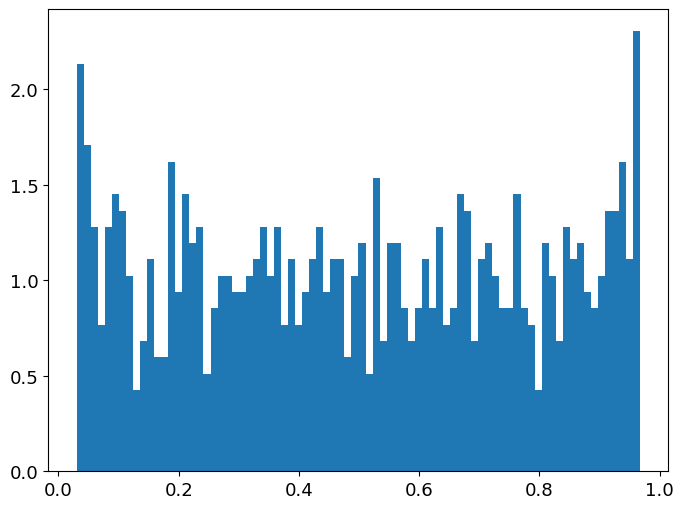

The current bandwidth is 0.07581095261619063.



array([0.03020853, 0.10781282, 0.20972374, 0.32650589, 0.44873786,
       0.56488008, 0.67670232, 0.78383735, 0.88506503, 0.96782664])

In [25]:
x_query = np.linspace(min(X_1), max(X_1), 10)

KDE(x=x_query.reshape(-1,1), data=X_1.reshape(-1,1))

plt.figure(figsize=(8,6))
plt.hist(KernelCDF(x=X_1, data=X_1), bins=80, density=True)
plt.show()

KernelCDF(x_query, data=X_1)